In [193]:
import numpy as np
from numpy.typing import NDArray
import pandas as pd
from typing import Optional, Tuple, Callable, Dict, Any, Sequence

from votekit.metrics import euclidean_dist
from votekit.pref_profile import RankProfile

def spatial_profile_from_types_profile_marked_data(
    number_of_ballots: int,
    candidates: list[str],
    voter_dist: Callable[..., np.ndarray] = np.random.uniform,
    voter_dist_kwargs: Optional[Dict[str, Any]] = None,
    candidate_dist: Callable[..., np.ndarray] = np.random.uniform,
    candidate_dist_kwargs: Optional[Dict[str, Any]] = None,
    distance: Callable[[np.ndarray, np.ndarray], float] = euclidean_dist,
) -> Tuple[RankProfile, dict[str, np.ndarray], np.ndarray]:
    """
    Samples a metric position for number_of_ballots voters from
    the voter distribution. Samples a metric position for each candidate
    from the input candidate distribution. With sampled
    positions, this method then creates a ranked RankProfile in which
    voter's preferences are consistent with their distances to the candidates
    in the metric space.

    Args:
        number_of_ballots (int): The number of ballots to generate.
        by_bloc (bool): Dummy variable from parent class.

    Returns:
        Tuple[RankProfile, dict[str, numpy.ndarray], numpy.ndarray]:
            A tuple containing the preference profile object,
            a dictionary with each candidate's position in the metric
            space, and a matrix where each row is a single voter's position
            in the metric space.
    """
    if voter_dist_kwargs is None:
        if voter_dist is np.random.uniform:
            voter_dist_kwargs = {"low": 0.0, "high": 1.0, "size": 2.0}
        else:
            voter_dist_kwargs = {}

    try:
        voter_dist(**voter_dist_kwargs)
    except TypeError:
        raise TypeError("Invalid kwargs for the voter distribution.")

    if candidate_dist_kwargs is None:
        if candidate_dist is np.random.uniform:
            candidate_dist_kwargs = {"low": 0.0, "high": 1.0, "size": 2.0}
        else:
            candidate_dist_kwargs = {}

    try:
        candidate_dist(**candidate_dist_kwargs)
    except TypeError:
        raise TypeError("Invalid kwargs for the candidate distribution.")

    try:
        v = voter_dist(**voter_dist_kwargs)
        c = candidate_dist(**candidate_dist_kwargs)
        distance(v.pos, c)
    except TypeError:
        raise TypeError(
            "Distance function is invalid or incompatible "
            "with voter/candidate distributions."
        )

    candidate_position_dict = {
        c: candidate_dist(**candidate_dist_kwargs) for c in candidates
    }

    voters = np.array(
        [voter_dist(**voter_dist_kwargs) for _ in range(number_of_ballots)]
    )
    voter_positions = np.array([v.pos for v in voters])

    ballot_pool = np.full((number_of_ballots, len(candidates)), frozenset("~"))

    for i in range(number_of_ballots):
        distance_tuples = [
            (c, distance(voter_positions[i], c_position))
            for c, c_position, in candidate_position_dict.items()
        ]
        candidate_ranking = np.array(
            [frozenset({t[0]}) for t in sorted(distance_tuples, key=lambda x: x[1])]
        )
        ballot_pool[i] = candidate_ranking

    n_candidates = len(candidates)
    df = pd.DataFrame(ballot_pool)
    df.index.name = "Ballot Index"
    df.columns = [f"Ranking_{i + 1}" for i in range(n_candidates)]
    df["Weight"] = 1
    df["Voter Set"] = [frozenset()] * len(df)
    return (
        RankProfile(
            candidates=candidates,
            df=df,
            max_ranking_length=n_candidates,
        ),
        candidate_position_dict,
        voters
    )

In [201]:
import votekit.ballot_generator.std_generator.spacial as spacial
import votekit.ballot_generator as bg
import numpy as np
from collections import Counter

class Person:
    def __init__(self, pos, identifier=""):
        self.pos = pos
        self.identifier = identifier

class PersonType:
    def __init__(self, generator,name="", region=""):
        self.gen = generator
        self.name = name
        self.region = region

    def identifier(self):
        return self.region + '.' + self.name
    
    def __call__(self):
        # Generate one voter
        return Person(self.gen(),self.identifier())

    def copy(self):
        return PersonType(self.gen, self.name, self.region)

    def sample(self, n):
        # Generate n voters
        return np.array([Person(self.gen(),self.identifier()) for _ in range(n)])

    def uniform_L_infinity_ball(x,y,r=1,name="",region=""):
        # Uniform Distribution
        gen = lambda: np.random.uniform(low= (x-r,y-r),high= (x+r,y+r),size= 2)
        return PersonType(gen,name,region)

    def uniform_L1_ball(x,y,r=1, name="",region=""):
        # L1 Distribution
        def gen():
            numbers = np.random.exponential(1, size = 2) # Picks two random numbers 
            normalized_numbers = numbers / numbers.sum() # Normalize so their sum adds to one
            signs = np.random.choice([-1,1], size = 2)
            points = signs * normalized_numbers # Some point on the boundary
            radius = r * (np.random.uniform(0,1) ** (1/2))
            return np.array([x,y]) + radius * points
        return PersonType(gen,name,region)

    def uniform_L2_ball(x,y,r=1,name="",region=""):
        #L2 Distribution
        def gen():
            # Pick angle and radius on a circle of radius 1
            theta = np.random.uniform(0, 2*np.pi)
            radius = r * np.sqrt(np.random.uniform(0, 1))
            return np.array([x, y]) + rad * np.array([np.cos(theta), np.sin(theta)])
        return PersonType(gen, name,region)

    def gaussian(x, y, sigma=0.5, name="",region=""):
        # Gaussian Moment, sigma is the standard deviation 
        gen = lambda: np.random.normal(loc=(x, y), scale=sigma, size=2)
        return PersonType(gen, name,region)

    def correlated_gaussian(mean, cov, name="",region=""):
        #Correlated Gaussian with full covariance.
        mean = np.array(mean, dtype=float)
        cov = np.array(cov, dtype=float)
        gen = lambda: np.random.multivariate_normal(mean= mean, cov=cov)
        return PersonType(gen, name,region)

    def combine(voter_types,name="",region=""):
        assert sum(voter_types.values()) == 1, "Need to have proportions"
        def gen():
            my_guy = np.random.choice(voter_types.keys(), p=voter_types.values())
            return my_guy.gen()
        return PersonType(gen, name, region)


class Region:
    def __init__(self,voter_types,name=""):
        self.voters=voter_types
        self.voter_types=list(voter_types.keys())
        self.amounts = list(voter_types.values())
        self.name = name
        assert len(self.voter_types) == len(self.amounts), "Dude What"
        
        tot = sum(self.amounts)
        self.proportions = [x/tot for x in self.amounts]

    def gen_one_random(self):
        my_guy = np.random.choice(self.voter_types, p=self.proportions)
        return my_guy()

    def combine(regions,name=None):
        if name == None:
            name = "__".join(region.name for region in regions)
        combined = {}
        for region in regions:
            for voter_type, amount in region.voters.items():
                new_voter_type = voter_type.copy()
                new_voter_type.region = region.name
                #print(new_voter_type.region)
                combined[new_voter_type] = amount
                #combined[voter_type] = combined.get(voter_type, 0) + amount
        return Region(combined,name)
        

def voter_generator_R_sep(R=0):
    first_rand = {"low": (-1,-1),"high": (1,1), "size": 2}
    second_rand = {"low": (-1,R-1),"high": (1,R+1), "size": 2}
    choose = np.random.rand(1)
    if choose < 1/2:
        return np.random.uniform(**first_rand)
    else:
        return np.random.uniform(**second_rand)

def candidate_generator_R_sep(R=0):
    return np.random.uniform(**{"low": (-1,-1), "high": (-1,R+1), "size": 2})
    

In [279]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors

marker_list = ['o','x','v','^','1','s','P','+','*','2']
def gen_voter_display_type(voter_names, voter_regions):
    shape_type = {}
    color_type = {}
    tot_voters = len(voter_names)
    assert len(voter_regions) <= len(marker_list)
    voter_name_ct = 0
    for v in voter_names:
        region_ct = 0
        voter_color = tuple(matplotlib.colors.hsv_to_rgb((voter_name_ct/tot_voters,1,1)))
        for r in voter_regions:
            shape_type[r+'.'+v] = marker_list[region_ct]
            color_type[r+'.'+v] = voter_color
            region_ct += 1
        voter_name_ct += 1
    return shape_type, color_type

def display_by_type(voter_data, cands, shape_type, color_type):
    data_sorted = defaultdict(list)
    
    for d in voter_data:
        s = shape_type[d.identifier]
        c = color_type[d.identifier]
        data_sorted[(s,c)].append(d.pos)
    for k,v in data_sorted.items():
        plt.scatter([x[0] for x in v],[x[1] for x in v],marker=k[0],color=k[1])
    #fig, ax = plt.subplots()
    for name,pos,color,marker in cands:
        plt.scatter(pos[0],pos[1], marker=marker,color=color)
        plt.annotate(name,pos)
    
    return plt.show()

def region_generator(region,num_ballots,candidate_list,candidate_dist,cand_kwargs):
    return spatial_profile_from_types_profile_marked_data(
        number_of_ballots= num_ballots,
        candidates= candidate_list,
        voter_dist=region.gen_one_random,
        candidate_dist = candidate_dist,
        candidate_dist_kwargs=cand_kwargs)

In [317]:
voter_type_K = PersonType.gaussian(0,0,name="K")
voter_type_L = PersonType.gaussian(0,10,name="L")
voter_type_M = PersonType.gaussian(1,5,name="M")
region_1 = Region({voter_type_K:100,voter_type_L:100},"R1")
region_2 = Region({voter_type_K:100,voter_type_L:100,voter_type_M: 200},"R2")
region_3=Region.combine([region_1,region_2])


cand_dist = np.random.uniform
cand_kwargs = {'low': (-1.5,-1), 'high': (1.5,10), 'size': 2}
prof, cands, data = region_generator(region_3,200, alphabet[0:20], cand_dist,cand_kwargs)

In [318]:
def prepare_candidates_for_display(cand_pos, cand_colors, winners=None, winner_color = 'm',cand_markers=None):
    cands = []
    for k,pos in cand_pos.items():
        color = cand_colors[k]
        if winners != None and k in winners:
            color = winner_color
        cands.append((k,pos,color,'+'))
    return cands

In [319]:
shape_type = {
    "R1.K": '^',
    "R1.L": '^',
    "R2.K": 'x',
    "R2.L": 'x'
}

color_type = {
    "R1.K": 'b',
    "R1.L": 'r',
    "R2.K": 'b',
    "R2.L": 'r',
    "E": 'g'
}
gen_voter_display_type(["K","L"],["R1","R2"])

({'R1.K': 'o', 'R2.K': 'x', 'R1.L': 'o', 'R2.L': 'x'},
 {'R1.K': (np.float64(1.0), np.float64(0.0), np.float64(0.0)),
  'R2.K': (np.float64(1.0), np.float64(0.0), np.float64(0.0)),
  'R1.L': (np.float64(0.0), np.float64(1.0), np.float64(1.0)),
  'R2.L': (np.float64(0.0), np.float64(1.0), np.float64(1.0))})

['R', 'E', 'P']


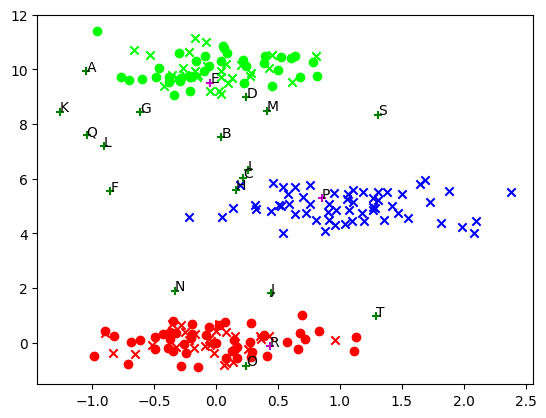

In [321]:
def clean_winners(wins):
    winners = []
    for cset in wins:
        for c in cset:
            winners.append(c)
    return winners

winners = clean_winners(Plurality(prof,m=3).get_elected())
print(winners)
cands_data = prepare_candidates_for_display(cands, defaultdict(lambda: 'g'), winners=winners)
voter_display_info = gen_voter_display_type(["K","L","M"],["R1","R2"])

display_by_type(data,cands_data,*voter_display_info)

In [286]:
from votekit.elections import STV,Borda,Plurality
STV(prof,m=4).get_elected()

Initial tiebreak was unsuccessful, performing random tiebreak
Initial tiebreak was unsuccessful, performing random tiebreak
Initial tiebreak was unsuccessful, performing random tiebreak
Initial tiebreak was unsuccessful, performing random tiebreak
Initial tiebreak was unsuccessful, performing random tiebreak
Initial tiebreak was unsuccessful, performing random tiebreak
Initial tiebreak was unsuccessful, performing random tiebreak
Initial tiebreak was unsuccessful, performing random tiebreak
Initial tiebreak was unsuccessful, performing random tiebreak
Initial tiebreak was unsuccessful, performing random tiebreak


(frozenset({'A'}), frozenset({'L'}), frozenset({'S'}), frozenset({'F'}))

In [255]:
Borda(prof).score_function(prof)

{'H': np.float64(2230.0),
 'N': np.float64(2147.0),
 'T': np.float64(2119.0),
 'O': np.float64(2156.0),
 'E': np.float64(2055.0),
 'M': np.float64(2037.0),
 'J': np.float64(2193.0),
 'L': np.float64(1915.0),
 'I': np.float64(2121.0),
 'G': np.float64(1902.0),
 'F': np.float64(2021.0),
 'B': np.float64(1947.0),
 'Q': np.float64(2046.0),
 'C': np.float64(2127.0),
 'S': np.float64(2161.0),
 'D': np.float64(1929.0),
 'A': np.float64(2183.0),
 'K': np.float64(2356.0),
 'R': np.float64(2275.0),
 'P': np.float64(2080.0)}

In [224]:
alphabet = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

In [225]:
alphabet

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']